In [24]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


In [26]:
df = pd.read_csv('loan_approval_dataset.csv')
df.head(3)
df = df.drop(columns=['loan_id'])


In [28]:
# 3. Define X, y
y = df[' loan_amount']
X = df.drop(columns=[' loan_amount'])


In [30]:
# 4. Identify numeric vs. categorical
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()

# 5a. Impute & scale numerics
num_imp = SimpleImputer(strategy='median')
X_num = pd.DataFrame(
    num_imp.fit_transform(X[num_cols]),
    columns=num_cols,
    index=X.index
)
scaler = StandardScaler()
X_num = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=num_cols,
    index=X.index
)

# 5b. One-hot encode categoricals
X_cat = pd.get_dummies(
    X[cat_cols].fillna('Missing'),
    drop_first=False,
    prefix=cat_cols
)


In [32]:
# 5c. Assemble processed feature matrix
X_proc = pd.concat([X_num, X_cat], axis=1)
print("Processed feature matrix shape:", X_proc.shape)
X_proc.head()

Processed feature matrix shape: (4269, 14)


,no_of_dependents,income_annum,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,education_ Graduate,education_ Not Graduate,self_employed_ No,self_employed_ Yes,loan_status_ Approved,loan_status_ Rejected
0,-0.294102,1.617979,0.192617,1.032792,-0.780058,2.877289,0.832028,0.930304,True,False,True,False,True,False
1,-1.473548,-0.341750,-0.508091,-1.061051,-0.733924,-0.631921,-0.694993,-0.515936,False,True,False,True,False,True
2,0.295621,1.439822,1.594031,-0.544840,-0.057300,-0.107818,1.996520,2.407316,True,False,True,False,False,True
3,0.295621,1.119139,-0.508091,-0.771045,1.649637,-0.381263,0.897943,0.899533,True,False,True,False,False,True
4,1.475067,1.689242,1.594031,-1.264055,0.757724,0.735304,1.568075,0.007172,False,True,False,True,False,True


In [6]:
# 6. Lasso + GridSearchCV
grid = {'alpha': [1e-4, 1e-2, 1e-1, 1, 10, 1e2, 1e3, 1e4, 1e5]}
lasso = Lasso(max_iter=10000)

lassoCV = GridSearchCV(
    estimator=lasso,
    param_grid=grid,
    return_train_score=True,
    cv=5,
    n_jobs=-1
)
lassoCV.fit(X_proc, y)

print(f"\nBest α = {lassoCV.best_params_['alpha']}"
      f"   Valid R² = {lassoCV.best_score_.round(3)}")



Best α = 10000.0   Valid R² = 0.861


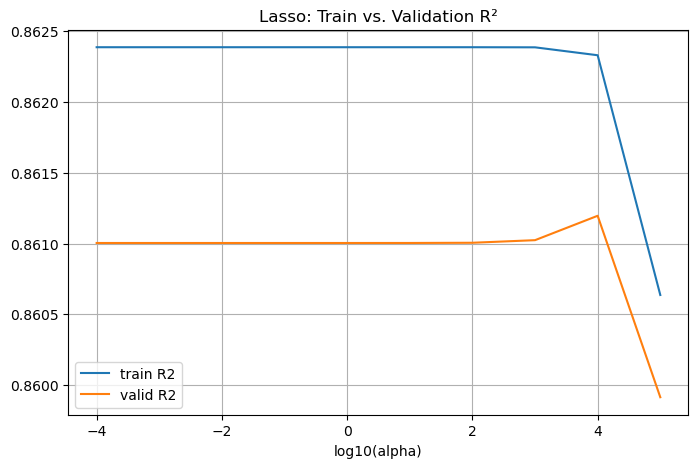

In [7]:
# 7. Plot train vs. validation R² over log10(alpha)
results = pd.DataFrame({
    'alpha'    : np.log10([p['alpha'] for p in lassoCV.cv_results_['params']]),
    'train R2' : lassoCV.cv_results_['mean_train_score'],
    'valid R2' : lassoCV.cv_results_['mean_test_score']
})

ax = results.plot.line(x='alpha', y='train R2', figsize=(8,5))
results.plot.line(x='alpha', y='valid R2', ax=ax)
ax.set_title('Lasso: Train vs. Validation R²')
ax.set_xlabel('log10(alpha)')
ax.grid(True)
plt.show()


In [8]:
# 8. Extract & sort coefficients
best_lasso = lassoCV.best_estimator_
coef = pd.Series(best_lasso.coef_, index=X_proc.columns)
coef = coef.sort_values()

print("Top 5 negative predictors:")
print(coef.head(5))
print("\nTop 5 positive predictors:")
print(coef.tail(5))


Top 5 negative predictors:
cibil_score             -3.641604e+05
no_of_dependents        -7.397465e+04
loan_status_ Rejected   -2.242130e-09
luxury_assets_value     -0.000000e+00
bank_asset_value        -0.000000e+00
dtype: float64

Top 5 positive predictors:
loan_term                   3.328841e+04
residential_assets_value    5.366294e+04
commercial_assets_value     1.262924e+05
loan_status_ Approved       1.100620e+06
income_annum                8.261328e+06
dtype: float64


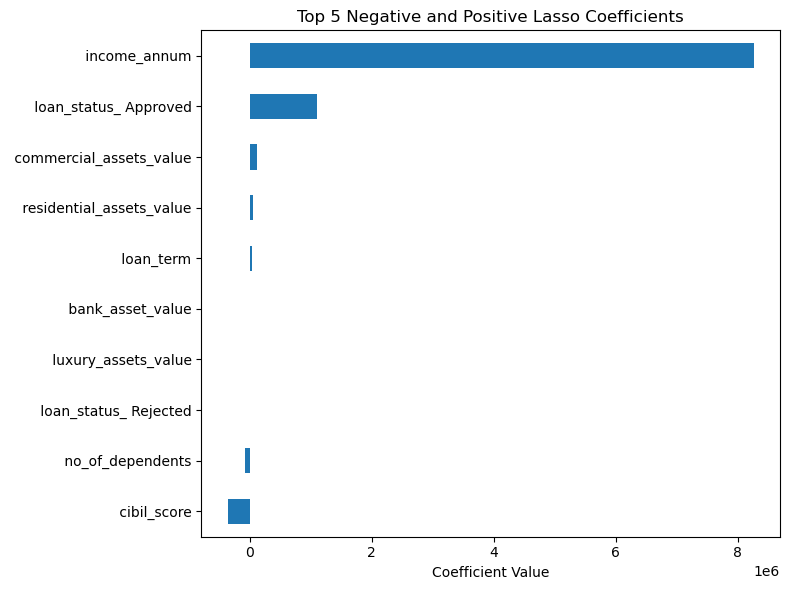

In [9]:
import matplotlib.pyplot as plt

# Sort and take extremes
coef_sorted = coef.sort_values()
top_neg = coef_sorted.head(5)
top_pos = coef_sorted.tail(5)
top = pd.concat([top_neg, top_pos])

# Plot
plt.figure(figsize=(8, 6))
top.plot.barh()
plt.title('Top 5 Negative and Positive Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()
